In [130]:
def main(
        # Architectural hyperparameters. These are quite small for illustrative purposes.
        initial_noise_size=5,  # How many noise dimensions to sample at the start of the SDE.
        noise_size=2,          # How many dimensions the Brownian motion has.
        hidden_size=16,        # How big the hidden size of the generator SDE and the discriminator CDE are.
        mlp_size=16,           # How big the layers in the various MLPs are.
        num_layers=1,          # How many hidden layers to have in the various MLPs.

        # Training hyperparameters. Be prepared to tune these very carefully, as with any GAN.
        generator_lr=2e-3,      # Learning rate often needs careful tuning to the problem.
        discriminator_lr=1e-2,  # Learning rate often needs careful tuning to the problem.
        batch_size=1024,        # Batch size.
        steps=500,            # How many steps to train both generator and discriminator for.
        init_mult1=3,           # Changing the initial parameter size can help.
        init_mult2=0.5,         #
        weight_decay=0.01,      # Weight decay.
        swa_step_start=5000,   # When to start using stochastic weight averaging.

        # Evaluation and plotting hyperparameters
        steps_per_print=10,                   # How often to print the loss.
        num_plot_samples=50,                  # How many samples to use on the plots at the end.
        plot_locs=(0.1, 0.3, 0.5, 0.7, 0.9),  # Plot some marginal distributions at this proportion of the way along.
        load_best_weights=True,  # Whether to load the best weights at the end of training
):
    # device = "mps"
    # print('HELLO?')
    # TODO: change
    is_cuda=torch.cuda.is_available()
    device='cuda' if is_cuda else 'cpu'
    if not is_cuda:
        print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

    # Data
    ts, data_size, train_dataloader=get_data(batch_size=batch_size, device=device)
    infinite_train_dataloader=(elem for it in iter(lambda: train_dataloader, None) for elem in it)

    # Models
    generator=HestonGenerator( noise_size, data_size, hidden_size, mlp_size, num_layers).to(device)
    discriminator=Discriminator(data_size, hidden_size, mlp_size, num_layers).to(device)
    # Weight averaging really helps with GAN training.
    averaged_generator=swa_utils.AveragedModel(generator)
    averaged_discriminator=swa_utils.AveragedModel(discriminator)

    # Picking a good initialisation is important!
    # In this case these were picked by making the parameters for the t=0 part of the generator be roughly the right
    # size that the untrained t=0 distribution has a similar variance to the t=0 data distribution.
    # Then the func parameters were adjusted so that the t>0 distribution looked like it had about the right variance.
    # What we're doing here is very crude -- one can definitely imagine smarter ways of doing things.
    # (e.g. pretraining the t=0 distribution)
    with torch.no_grad():
        # for param in generator._initial.parameters():
        #     param *=init_mult1
        for param in generator._func.parameters():
            param *=init_mult2

    # Optimisers. Adadelta turns out to be a much better choice than SGD or Adam, interestingly.
    generator_optimiser=torch.optim.Adadelta(generator.parameters(), lr=generator_lr, weight_decay=weight_decay)
    discriminator_optimiser=torch.optim.Adadelta(discriminator.parameters(), lr=discriminator_lr,
                                                   weight_decay=weight_decay)

    # Track the lowest loss and corresponding steps
    lowest_loss=float('inf')
    best_loss_steps=[]

    # Train both generator and discriminator.
    trange=tqdm.tqdm(range(steps))
    for step in trange:
        real_samples,=next(infinite_train_dataloader)

        generated_samples=generator(ts, batch_size)
        generated_score=discriminator(generated_samples)
        real_score=discriminator(real_samples)
        loss=generated_score - real_score
        loss.backward()

        for param in generator.parameters():
            param.grad *=-1
        generator_optimiser.step()
        discriminator_optimiser.step()
        generator_optimiser.zero_grad()
        discriminator_optimiser.zero_grad()

        ###################
        # We constrain the Lipschitz constant of the discriminator using carefully-chosen clipping (and the use of
        # LipSwish activation functions).
        ###################
        with torch.no_grad():
            for module in discriminator.modules():
                if isinstance(module, torch.nn.Linear):
                    lim=1 / module.out_features
                    module.weight.clamp_(-lim, lim)

        # Stochastic weight averaging typically improves performance.
        if step > swa_step_start:
            averaged_generator.update_parameters(generator)
            averaged_discriminator.update_parameters(discriminator)

        if (step % steps_per_print)==0 or step==steps - 1:
            total_unaveraged_loss=evaluate_loss(ts, batch_size, train_dataloader, generator, discriminator)
            if step > swa_step_start:
                total_averaged_loss=evaluate_loss(ts, batch_size, train_dataloader, averaged_generator.module,
                                                    averaged_discriminator.module)
                trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f} "
                             f"Loss (averaged): {total_averaged_loss:.4f}")
                
                # Save the model weights if the averaged loss is the lowest
                if total_averaged_loss < lowest_loss:
                    lowest_loss=total_averaged_loss
                    torch.save(averaged_generator.module.state_dict(), 'best_generator_heston.pth')
                    torch.save(averaged_discriminator.module.state_dict(), 'best_discriminator_heston.pth')
                    trange.write(f"New best model found at step {step}, saving model weights.")
                    # best_loss_steps.append(step)
            else:
                trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f}")
                
                # Save the model weights if the unaveraged loss is the lowest
                if total_unaveraged_loss < lowest_loss:
                    lowest_loss=total_unaveraged_loss
                    torch.save(generator.state_dict(), 'best_generator_heston.pth')
                    torch.save(discriminator.state_dict(), 'best_discriminator_heston.pth')
                    # trange.write(f"New best model found at step {step}, saving model weights.")
                    # best_loss_steps.append(step)

    # Load the best weights if the flag is set
    if load_best_weights:
        load_weights(generator, discriminator)

    # Set plot locations to be at the best loss locations
    # if best_loss_steps:
    #     best_loss_steps=sorted(best_loss_steps)
    #     plot_locs=[step / steps for step in best_loss_steps]

    time, dimension_of_SDE, test_dataloader=get_data(batch_size=batch_size, device=device)

    plot(ts, generator, test_dataloader, num_plot_samples, plot_locs)

  0%|          | 0/500 [00:00<?, ?it/s]/var/folders/dq/rqfnzblj563fyybzblp43v_w0000gn/T/ipykernel_47113/4285255001.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sqrt_1_minus_rho2=torch.sqrt(torch.tensor(1 - self.rho**2, device=S.device))
  0%|          | 1/500 [00:00<02:41,  3.08it/s]

Step:   0 Loss (unaveraged): -6.9477


  2%|▏         | 11/500 [00:02<02:08,  3.82it/s]

Step:  10 Loss (unaveraged): -6.4828


  4%|▍         | 21/500 [00:05<02:03,  3.88it/s]

Step:  20 Loss (unaveraged): -7.1448


  6%|▌         | 31/500 [00:07<02:01,  3.86it/s]

Step:  30 Loss (unaveraged): -7.5853


  8%|▊         | 41/500 [00:10<02:27,  3.12it/s]

Step:  40 Loss (unaveraged): -6.6181


 10%|█         | 51/500 [00:14<02:23,  3.13it/s]

Step:  50 Loss (unaveraged): -7.4399


 12%|█▏        | 61/500 [00:16<02:00,  3.65it/s]

Step:  60 Loss (unaveraged): -7.6125


 14%|█▍        | 71/500 [00:19<02:04,  3.44it/s]

Step:  70 Loss (unaveraged): -8.5482


 16%|█▌        | 81/500 [00:22<01:56,  3.60it/s]

Step:  80 Loss (unaveraged): -9.1737


 18%|█▊        | 91/500 [00:24<01:50,  3.69it/s]

Step:  90 Loss (unaveraged): -9.7367


 20%|██        | 101/500 [00:27<01:44,  3.80it/s]

Step: 100 Loss (unaveraged): -10.3415


 22%|██▏       | 111/500 [00:30<01:48,  3.59it/s]

Step: 110 Loss (unaveraged): -10.8983


 24%|██▍       | 121/500 [00:32<01:40,  3.76it/s]

Step: 120 Loss (unaveraged): -11.6173


 26%|██▌       | 131/500 [00:35<01:38,  3.73it/s]

Step: 130 Loss (unaveraged): -12.9734


 28%|██▊       | 141/500 [00:37<01:34,  3.79it/s]

Step: 140 Loss (unaveraged): -13.7778


 30%|███       | 151/500 [00:40<01:33,  3.73it/s]

Step: 150 Loss (unaveraged): -14.3346


 32%|███▏      | 161/500 [00:42<01:30,  3.76it/s]

Step: 160 Loss (unaveraged): -15.9740


 34%|███▍      | 171/500 [00:45<01:27,  3.76it/s]

Step: 170 Loss (unaveraged): -17.1340


 36%|███▌      | 181/500 [00:47<01:24,  3.79it/s]

Step: 180 Loss (unaveraged): -17.8003


 38%|███▊      | 191/500 [00:50<01:25,  3.61it/s]

Step: 190 Loss (unaveraged): -19.1822


 40%|████      | 201/500 [00:53<01:26,  3.46it/s]

Step: 200 Loss (unaveraged): -19.5344


 42%|████▏     | 211/500 [00:56<01:24,  3.43it/s]

Step: 210 Loss (unaveraged): -23.0234


 44%|████▍     | 221/500 [00:59<01:22,  3.37it/s]

Step: 220 Loss (unaveraged): -23.3935


 46%|████▌     | 231/500 [01:02<01:15,  3.56it/s]

Step: 230 Loss (unaveraged): -24.8764


 48%|████▊     | 241/500 [01:04<01:11,  3.63it/s]

Step: 240 Loss (unaveraged): -25.4895


 50%|█████     | 251/500 [01:07<01:06,  3.73it/s]

Step: 250 Loss (unaveraged): -29.1566


 52%|█████▏    | 261/500 [01:10<01:09,  3.44it/s]

Step: 260 Loss (unaveraged): -28.9161


 54%|█████▍    | 271/500 [01:12<01:03,  3.59it/s]

Step: 270 Loss (unaveraged): -32.0025


 56%|█████▌    | 281/500 [01:15<01:03,  3.47it/s]

Step: 280 Loss (unaveraged): -34.7804


 58%|█████▊    | 291/500 [01:18<00:57,  3.64it/s]

Step: 290 Loss (unaveraged): -34.9422


 60%|██████    | 301/500 [01:20<00:54,  3.67it/s]

Step: 300 Loss (unaveraged): -36.5212


 62%|██████▏   | 311/500 [01:23<01:04,  2.91it/s]

Step: 310 Loss (unaveraged): -40.5958


 64%|██████▍   | 321/500 [01:26<00:52,  3.40it/s]

Step: 320 Loss (unaveraged): -43.2307


 66%|██████▌   | 331/500 [01:29<00:50,  3.37it/s]

Step: 330 Loss (unaveraged): -33.1958


 68%|██████▊   | 341/500 [01:32<00:45,  3.48it/s]

Step: 340 Loss (unaveraged): -14.2174


 70%|███████   | 351/500 [01:34<00:42,  3.50it/s]

Step: 350 Loss (unaveraged): -12.1785


 72%|███████▏  | 361/500 [01:37<00:39,  3.55it/s]

Step: 360 Loss (unaveraged): 54.7923


 74%|███████▍  | 371/500 [01:40<00:36,  3.56it/s]

Step: 370 Loss (unaveraged): 63.8479


 76%|███████▌  | 381/500 [01:43<00:46,  2.55it/s]

Step: 380 Loss (unaveraged): 52.4895


 78%|███████▊  | 391/500 [01:47<00:36,  3.00it/s]

Step: 390 Loss (unaveraged): 51.9702


 80%|████████  | 401/500 [01:49<00:27,  3.62it/s]

Step: 400 Loss (unaveraged): 30.9936


 82%|████████▏ | 411/500 [01:52<00:23,  3.74it/s]

Step: 410 Loss (unaveraged): 16.1021


 84%|████████▍ | 421/500 [01:55<00:21,  3.60it/s]

Step: 420 Loss (unaveraged): 1.2620


 86%|████████▌ | 431/500 [01:57<00:19,  3.63it/s]

Step: 430 Loss (unaveraged): -23.9490


 88%|████████▊ | 441/500 [02:00<00:20,  2.82it/s]

Step: 440 Loss (unaveraged): -38.0261


 90%|█████████ | 451/500 [02:03<00:14,  3.43it/s]

Step: 450 Loss (unaveraged): -50.6868


 92%|█████████▏| 461/500 [02:06<00:11,  3.25it/s]

Step: 460 Loss (unaveraged): -61.1389


 94%|█████████▍| 471/500 [02:09<00:08,  3.42it/s]

Step: 470 Loss (unaveraged): -67.3719


 96%|█████████▌| 481/500 [02:12<00:05,  3.46it/s]

Step: 480 Loss (unaveraged): -85.5870


 98%|█████████▊| 491/500 [02:15<00:04,  2.16it/s]

Step: 490 Loss (unaveraged): -68.7346


100%|██████████| 500/500 [02:18<00:00,  3.62it/s]


Step: 499 Loss (unaveraged): -62.3335


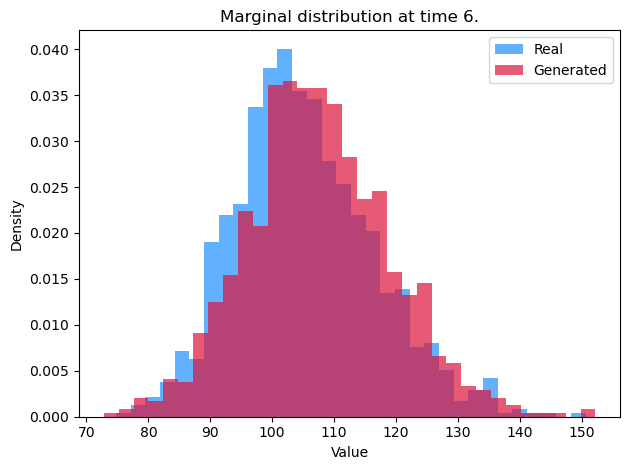

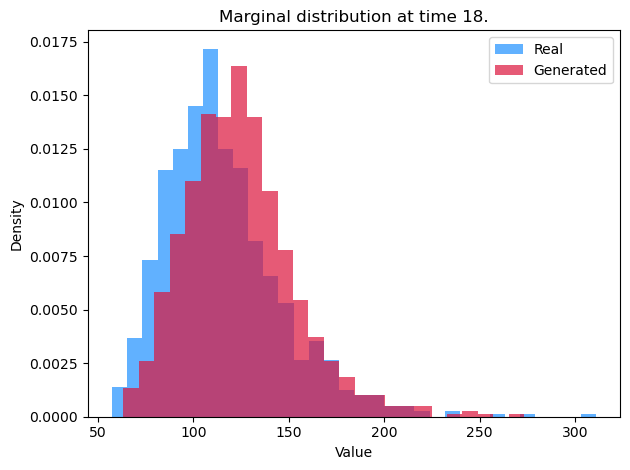

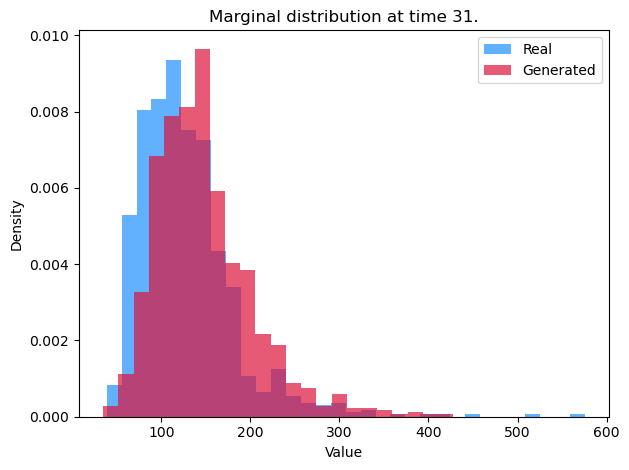

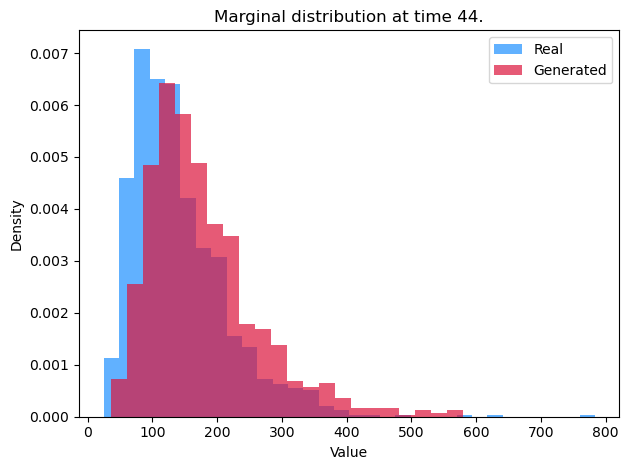

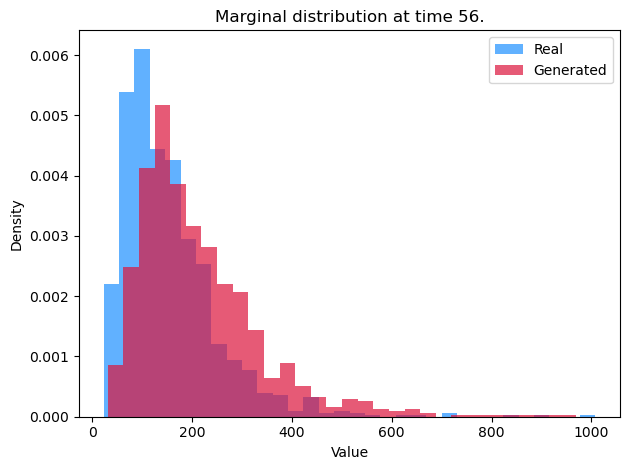

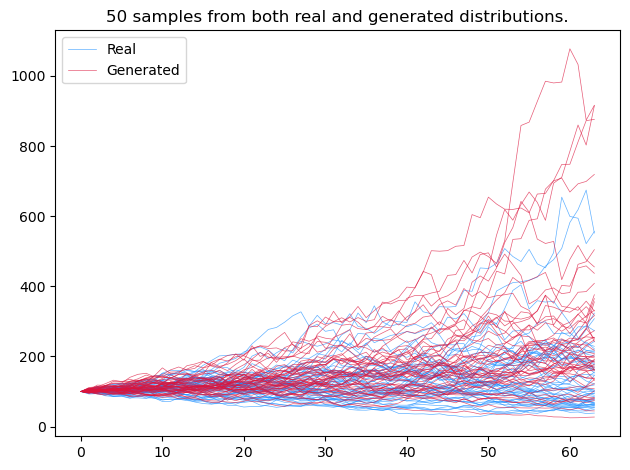

ERROR: Could not consume arg: --f=/Users/osianshelley/Library/Jupyter/runtime/kernel-v2-34511I2gtGXtq4yqj.json
Usage: ipykernel_launcher.py -

For detailed information on this command, run:
  ipykernel_launcher.py - --help


FireExit: 2

In [131]:
fire.Fire(main)

In [102]:
def main(
        # Architectural hyperparameters. These are quite small for illustrative purposes.
        initial_noise_size=5,  # How many noise dimensions to sample at the start of the SDE.
        noise_size=2,          # How many dimensions the Brownian motion has.
        hidden_size=16,        # How big the hidden size of the generator SDE and the discriminator CDE are.
        mlp_size=16,           # How big the layers in the various MLPs are.
        num_layers=1,          # How many hidden layers to have in the various MLPs.

        # Training hyperparameters. Be prepared to tune these very carefully, as with any GAN.
        generator_lr=2e-3,      # Learning rate often needs careful tuning to the problem.
        discriminator_lr=1e-2,  # Learning rate often needs careful tuning to the problem.
        batch_size=1024,        # Batch size.
        steps=500,            # How many steps to train both generator and discriminator for.
        init_mult1=3,           # Changing the initial parameter size can help.
        init_mult2=0.5,         #
        weight_decay=0.01,      # Weight decay.
        swa_step_start=5000,   # When to start using stochastic weight averaging.

        # Evaluation and plotting hyperparameters
        steps_per_print=2,                   # How often to print the loss.
        num_plot_samples=50,                  # How many samples to use on the plots at the end.
        plot_locs=(0.1, 0.3, 0.5, 0.7, 0.9),  # Plot some marginal distributions at this proportion of the way along.
        load_best_weights=True,  # Whether to load the best weights at the end of training
):
    # device = "mps"
    # print('HELLO?')
    # TODO: change
    is_cuda=torch.cuda.is_available()
    device='cuda' if is_cuda else 'cpu'
    if not is_cuda:
        print("Warning: CUDA not available; falling back to CPU but this is likely to be very slow.")

    # Data
    ts, data_size, train_dataloader=get_data(batch_size=batch_size, device=device)
    infinite_train_dataloader=(elem for it in iter(lambda: train_dataloader, None) for elem in it)

    # Models
    generator=HestonGenerator( noise_size, data_size, hidden_size, mlp_size, num_layers).to(device)
    discriminator=Discriminator(data_size, hidden_size, mlp_size, num_layers).to(device)
    # # Weight averaging really helps with GAN training.
    # averaged_generator=swa_utils.AveragedModel(generator)
    # averaged_discriminator=swa_utils.AveragedModel(discriminator)

    # # Picking a good initialisation is important!
    # # In this case these were picked by making the parameters for the t=0 part of the generator be roughly the right
    # # size that the untrained t=0 distribution has a similar variance to the t=0 data distribution.
    # # Then the func parameters were adjusted so that the t>0 distribution looked like it had about the right variance.
    # # What we're doing here is very crude -- one can definitely imagine smarter ways of doing things.
    # # (e.g. pretraining the t=0 distribution)
    # with torch.no_grad():
    #     # for param in generator._initial.parameters():
    #     #     param *=init_mult1
    #     for param in generator._func.parameters():
    #         param *=init_mult2

    # # Optimisers. Adadelta turns out to be a much better choice than SGD or Adam, interestingly.
    # generator_optimiser=torch.optim.Adadelta(generator.parameters(), lr=generator_lr, weight_decay=weight_decay)
    # discriminator_optimiser=torch.optim.Adadelta(discriminator.parameters(), lr=discriminator_lr,
    #                                                weight_decay=weight_decay)

    # # Track the lowest loss and corresponding steps
    # lowest_loss=float('inf')
    # best_loss_steps=[]

    # # Train both generator and discriminator.
    # trange=tqdm.tqdm(range(steps))
    # for step in trange:
    #     real_samples,=next(infinite_train_dataloader)

    #     generated_samples=generator(ts, batch_size)
    #     generated_score=discriminator(generated_samples)
    #     real_score=discriminator(real_samples)
    #     loss=generated_score - real_score
    #     loss.backward()

    #     for param in generator.parameters():
    #         param.grad *=-1
    #     generator_optimiser.step()
    #     discriminator_optimiser.step()
    #     generator_optimiser.zero_grad()
    #     discriminator_optimiser.zero_grad()

        ###################
        # We constrain the Lipschitz constant of the discriminator using carefully-chosen clipping (and the use of
        # LipSwish activation functions).
        # ###################
        # with torch.no_grad():
        #     for module in discriminator.modules():
        #         if isinstance(module, torch.nn.Linear):
        #             lim=1 / module.out_features
        #             module.weight.clamp_(-lim, lim)

        # # Stochastic weight averaging typically improves performance.
        # if step > swa_step_start:
        #     averaged_generator.update_parameters(generator)
        #     averaged_discriminator.update_parameters(discriminator)

        # if (step % steps_per_print)==0 or step==steps - 1:
        #     total_unaveraged_loss=evaluate_loss(ts, batch_size, train_dataloader, generator, discriminator)
        #     if step > swa_step_start:
        #         total_averaged_loss=evaluate_loss(ts, batch_size, train_dataloader, averaged_generator.module,
        #                                             averaged_discriminator.module)
        #         # trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f} "
        #         #              f"Loss (averaged): {total_averaged_loss:.4f}")
                
        #         # Save the model weights if the averaged loss is the lowest
        #         if total_averaged_loss < lowest_loss:
            #         lowest_loss=total_averaged_loss
            #         torch.save(averaged_generator.module.state_dict(), 'best_generator_heston.pth')
            #         torch.save(averaged_discriminator.module.state_dict(), 'best_discriminator_heston.pth')
            #         # trange.write(f"New best model found at step {step}, saving model weights.")
            #         # best_loss_steps.append(step)
            # else:
            #     # trange.write(f"Step: {step:3} Loss (unaveraged): {total_unaveraged_loss:.4f}")
                
            #     # Save the model weights if the unaveraged loss is the lowest
            #     if total_unaveraged_loss < lowest_loss:
            #         lowest_loss=total_unaveraged_loss
            #         torch.save(generator.state_dict(), 'best_generator_heston.pth')
            #         torch.save(discriminator.state_dict(), 'best_discriminator_heston.pth')
            #         # trange.write(f"New best model found at step {step}, saving model weights.")
            #         # best_loss_steps.append(step)

    # Load the best weights if the flag is set
    if load_best_weights:
        load_weights(generator, discriminator)

    # Set plot locations to be at the best loss locations
    # if best_loss_steps:
    #     best_loss_steps=sorted(best_loss_steps)
    #     plot_locs=[step / steps for step in best_loss_steps]

    time, dimension_of_SDE, test_dataloader=get_data(batch_size=batch_size, device=device)

    plot(ts, generator, test_dataloader, num_plot_samples, plot_locs)

/var/folders/dq/rqfnzblj563fyybzblp43v_w0000gn/T/ipykernel_47113/3683559043.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sqrt_1_minus_rho2=torch.sqrt(torch.tensor(1 - self.rho**2, device=S.device))


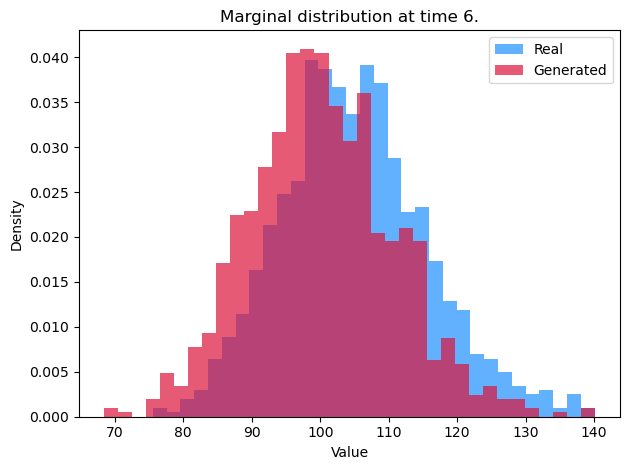

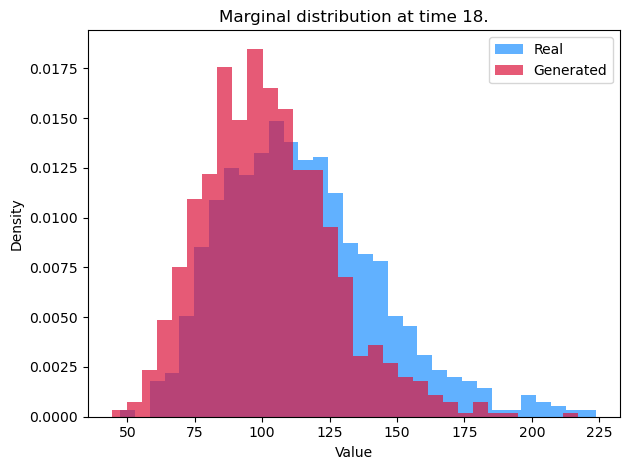

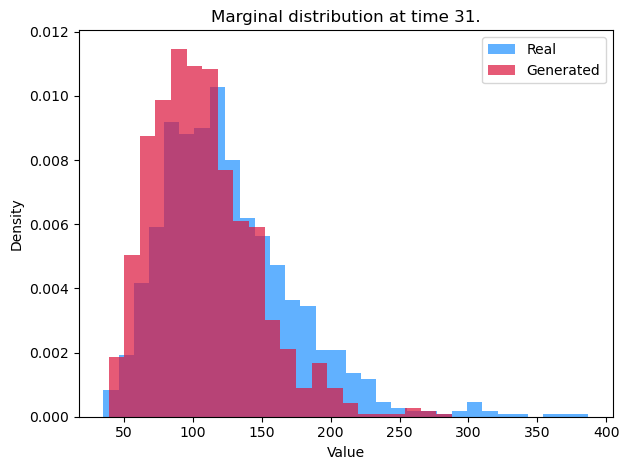

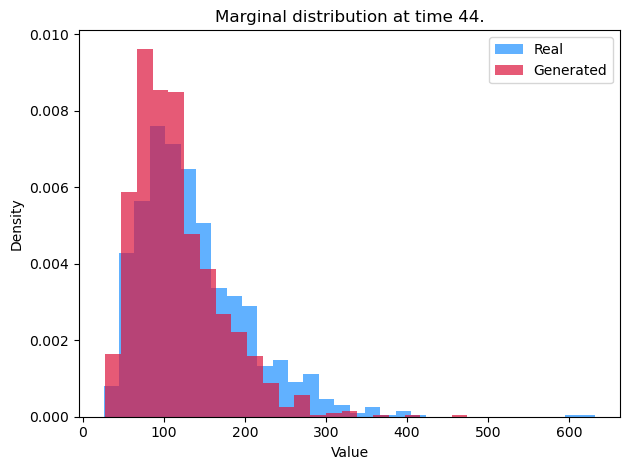

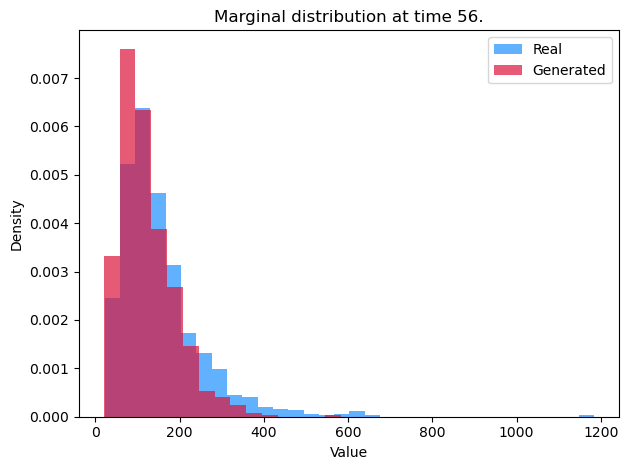

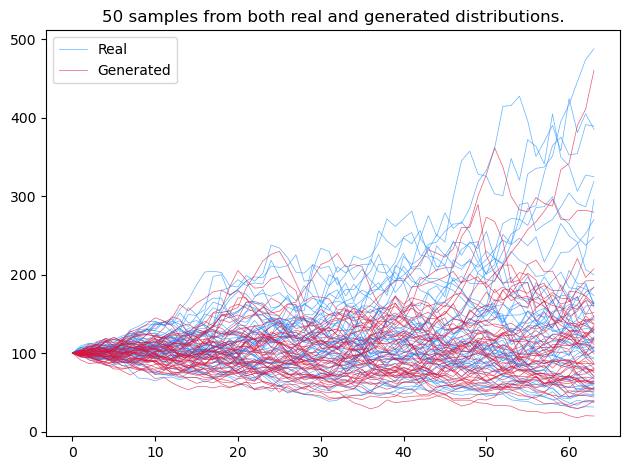

ERROR: Could not consume arg: --f=/Users/osianshelley/Library/Jupyter/runtime/kernel-v2-34511I2gtGXtq4yqj.json
Usage: ipykernel_launcher.py -

For detailed information on this command, run:
  ipykernel_launcher.py - --help


FireExit: 2

In [111]:
fire.Fire(main)